In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter
from matplotlib import cm
from skimage import color
from skimage import io
import numba
from numba import jit

Laplaces Equation:

$$\nabla^2 V=0$$

everywhere in the square. We are in 2D, so this means

$$\frac{\partial^2 V}{\partial x^2}+\frac{\partial^2 V}{\partial y^2}=0$$

This equation can be discretely approximated as

$$\frac{V(x_{i+1}, y_j) - 2V(x_i, y_j) + V(x_{i-1}, y_j)}{(\Delta x)^2} + \frac{V(x_i, y_{j+1}) - 2V(x_i, y_j) + V(x_i, y_{j-1})}{(\Delta y)^2} = 0 $$

Noting that $ \Delta x = \Delta y$ in our array, we can solve for $V(x_i, y_j)$ yielding

$$V(x_i, y_j) = \frac{1}{4}(V(x_{i+1}, y_{j}) + V(x_{i-1}, y_{j}) + V(x_{i}, y_{j+1}) + V(x_{i}, y_{j-1}))$$

So the idea is that if repeatedly set

$$V(x_i, y_j) \to \frac{1}{4}(V(x_{i+1}, y_{j}) + V(x_{i-1}, y_{j}) + V(x_{i}, y_{j+1}) + V(x_{i}, y_{j-1}))$$

$V$ will eventually converge to the true solution

# Part 1: Boundaries Only

Define the boundary conditions

In [2]:
edge = np.linspace(-1, 1, 300)
upper_y = np.cos(np.pi * edge / 2)
lower_y = edge**4
upper_x = 1/(np.e**-1 - np.e) * (np.exp(edge)-np.e)
lower_x = 0.5 * (edge**2-edge)

Get a meshgrid

In [3]:
xv, yv = np.meshgrid(edge, edge)

Define function to solve for the potential

In [4]:
@numba.jit("f8[:,:](f8[:,:], i8)", nopython=True, nogil=True)
def compute_potential(potential, n_iter):
    length = len(potential[0])
    for n in range(n_iter):
        for i in range(1, length-1):
            for j in range(1, length-1):
                potential[j][i] = 1/4 * (potential[j+1][i] + potential[j-1][i] + potential[j][i+1] + potential[j][i-1])
    return potential

Solve for potential

In [5]:
potential = np.zeros((300,300))
potential[0,:]= lower_y
potential[-1,:]= upper_y
potential[:,0]= lower_x
potential[:,-1]= upper_x
potential = compute_potential(potential, n_iter=10000)

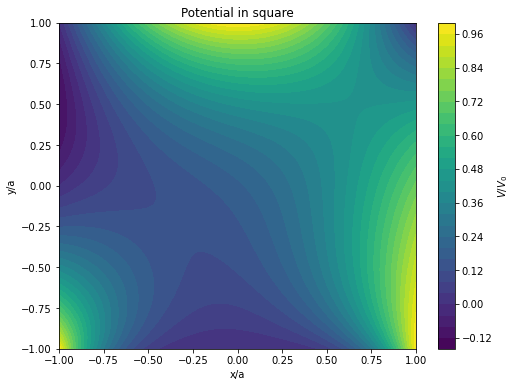

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
clr_plot = ax.contourf(xv, yv, potential, 30)
ax.set_xlabel('x/a')
ax.set_ylabel('y/a')
fig.colorbar(clr_plot, label='$V/V_0$')
ax.set_title('Potential in square')
plt.show()

# With a Block of Fixed Potential

Define a block which is set at a constant potential of $V=1$

In [7]:
def potential_block(x, y):
    return np.select([(x>0.5)*(x<0.7)*(y>0.5)*(y<0.7),
                      (x<=0.5)+(x>=0.7)+(y<=0.5)+(y>=0.7)],
                     [1.,
                      0])

Show the location of the fixed potential

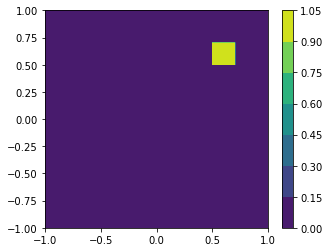

In [8]:
plt.figure(figsize=(5,4))
plt.contourf(xv, yv, potential_block(xv,yv))
plt.colorbar()

Obtain the fixed potential, and the places where the potential is fixed

In [9]:
fixed = potential_block(xv,yv)
fixed_bool = fixed!=0

Modify the compute potential function so it doesn't set the modify the points at the fixed potential during the training procedure

In [10]:
@numba.jit("f8[:,:](f8[:,:], b1[:,:], i8)", nopython=True, nogil=True)
def compute_potential(potential, fixed_bool, n_iter):
    length = len(potential[0])
    for n in range(n_iter):
        for i in range(1, length-1):
            for j in range(1, length-1):
                if not(fixed_bool[j][i]):
                    potential[j][i] = 1/4 * (potential[j+1][i] + potential[j-1][i] + potential[j][i+1] + potential[j][i-1])
    return potential

Solve for the potential

In [11]:
potential = np.zeros((300,300))
potential[0,:]= lower_y
potential[-1,:]= upper_y
potential[:,0]= lower_x
potential[:,-1]= upper_x
potential[fixed_bool] = fixed[fixed_bool]
potential = compute_potential(potential, fixed_bool, n_iter=10000)

Plot

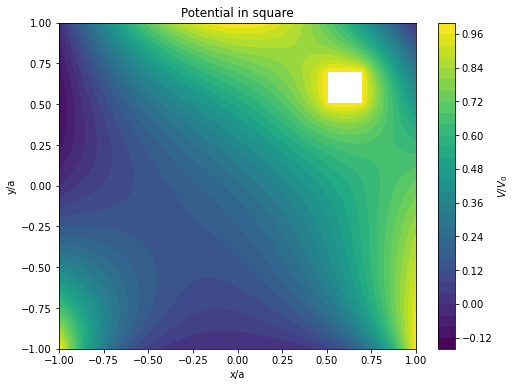

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
clr_plot = ax.contourf(xv, yv, potential, 30)
ax.set_xlabel('x/a')
ax.set_ylabel('y/a')
fig.colorbar(clr_plot, label='$V/V_0$')
ax.set_title('Potential in square')
plt.show()

# For an Image

Load image

In [13]:
img = color.rgb2gray(io.imread('../../output/accordion.png'))
img = np.flip(img, axis=0)

<ipython-input-13-e26fc1222814>:1: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  img = color.rgb2gray(io.imread('../../output/accordion.png'))


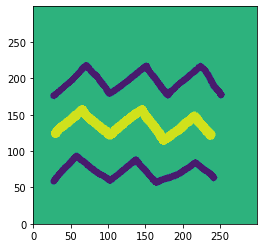

In [14]:
plt.figure(figsize=(4,4))
plt.contourf(img)

Solve for potential

In [15]:
potential = np.zeros((300,300))
HV_bool = img<0.05
LV_bool = img>0.95
fixed_bool = HV_bool + LV_bool
fixed = img
potential[fixed_bool] = fixed[fixed_bool]
potential[0,:]= lower_y
potential[-1,:]= upper_y
potential[:,0]= lower_x
potential[:,-1]= upper_x
potential = compute_potential(potential, fixed_bool, n_iter=10000)

Plot potential

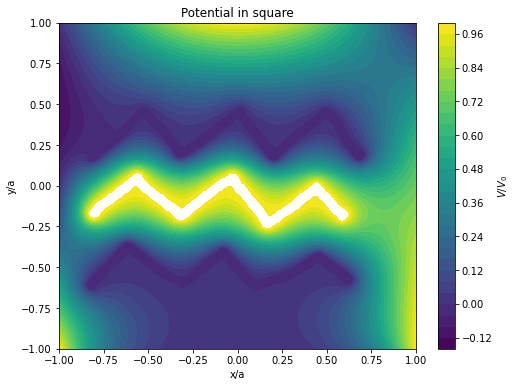

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
clr_plot = ax.contourf(xv, yv, potential, 30)
ax.set_xlabel('x/a')
ax.set_ylabel('y/a')
fig.colorbar(clr_plot, label='$V/V_0$')
ax.set_title('Potential in square')
plt.show()

Can look at electric field magnitude too!

In [17]:
Ex, Ey = np.gradient(-potential)
E_mag = np.sqrt(Ex**2 + Ey**2)

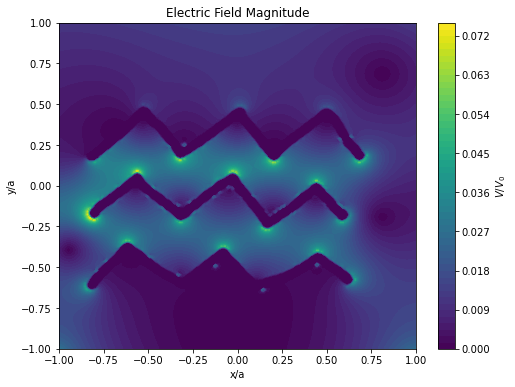

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
clr_plot = ax.contourf(xv, yv, E_mag, 50)
ax.set_xlabel('x/a')
ax.set_ylabel('y/a')
fig.colorbar(clr_plot, label='$V/V_0$')
ax.set_title('Electric Field Magnitude')
plt.show()

In [19]:
def init():
    # Plot the surface.
    ax.plot_surface(xv, yv, potential, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
    ax.set_xlabel('$x/a$')
    ax.set_ylabel('$y/a$')
    return fig,

def animate(i):
    ax.view_init(elev=30, azim=2*i)
    return fig,

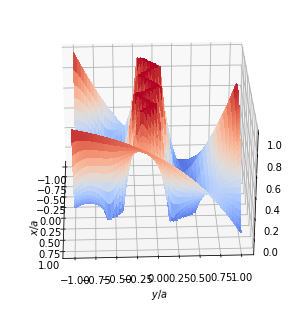

In [20]:
fig = plt.figure()
ax = Axes3D(fig)
ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=180, interval=50)
ani.save('rotate_azimuth_angle_3d_surf.gif',writer='pillow',fps=20)